In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
import keras
print(keras.__version__)

2.3.1


Using TensorFlow backend.


In [4]:
import sys
!{sys.executable} -m pip install h5py==2.9.0

In [5]:
!pip3 install scikit-image
!pip3 install opencv-python

In [6]:
import skimage
print(skimage.__version__)

0.16.2


In [7]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

fatal: destination path 'Mask-RCNN-TF2' already exists and is not an empty directory.


In [8]:
!ls ./Mask-RCNN-TF2

assets				  Mask-RCNN-TF2
images				  mrcnn
Kangaro_mask_rcnn_trained.h5	  mrcnn_directed
kangaroo-transfer-learning	  README.md
LICENSE				  requirements.txt
MANIFEST.in			  samples
mask_rcnn_coco.h5		  setup.cfg
maskrcnn_predict_directed.py	  setup.py
maskrcnn_predict_directed_RPN.py  test.jpg
maskrcnn_predict.py


In [9]:
cd ./Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo

/content/Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo


In [10]:
!ls

annots	images


In [11]:
import xml
im_name = "00060"
with open("./annots/" + im_name + ".xml") as f:
  print(f.read())



<annotation>
	<folder>Kangaroo</folder>
	<filename>00060.jpg</filename>
	<path>/home/andy/Desktop/Kangaroo/16083178617_e4c90bda77_z.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>640</width>
		<height>427</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>300</xmin>
			<ymin>106</ymin>
			<xmax>500</xmax>
			<ymax>369</ymax>
		</bndbox>
	</object>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>133</xmin>
			<ymin>213</ymin>
			<xmax>333</xmax>
			<ymax>425</ymax>
		</bndbox>
	</object>
</annotation>



In [12]:
# parse an xml file

import skimage.io 
import matplotlib.pyplot , matplotlib.patches

def extract_boxes(filename):
  tree = xml.etree.ElementTree.parse(filename)

  root = tree.getroot()

  boxes = list()

  for box in root.findall(".//bndbox"):
    xmin = int(box.find("xmin").text)
    ymin = int(box.find("ymin").text)
    xmax = int(box.find("xmax").text)
    ymax = int(box.find("ymax").text)

    coors = [xmin , ymin , xmax , ymax]

    boxes.append(coors)
  return boxes

there are 2 objects in the image
bboxes: [[300, 106, 500, 369], [133, 213, 333, 425]]



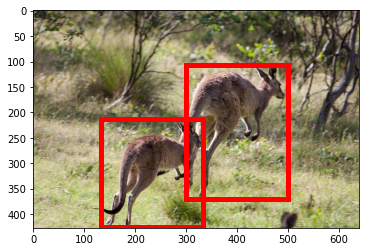

In [13]:
im_name = "00060"
img = skimage.io.imread("./images/" + im_name + ".jpg")

boxes = extract_boxes("./annots/"+im_name+".xml")
print("there are {count} objects in the image".format(count=len(boxes)))
print("bboxes:", boxes, end="\n\n")

fig, ax = matplotlib.pyplot.subplots()
ax.imshow(img)

for box_idx in range(len(boxes)):
  rect = matplotlib.patches.Rectangle( (boxes[box_idx][0], boxes[box_idx][1]),
                                       boxes[box_idx][2]-boxes[box_idx][0], boxes[box_idx][3]-boxes[box_idx][1],
                                       linewidth = 5, edgecolor="r", facecolor="none")
  
  ax.add_patch(rect)


matplotlib.pyplot.show()

In [14]:
%cd ../..

/content/Mask-RCNN-TF2


In [15]:
# 6 steps to train model:
# 1. prepare the train and validation datasets using mrcnn.utils.Dataset class
# 2. prepare the model configuration params using mrcnn.config.Config class
# 3. build mask rcnn model architecture by using mrcnn.model.MaskRCNN class
# 4. downloading and loading the pretrained weights
# 5. training the model
# saving the trained weights



In [16]:
###1. EXTEND mcrnn.utils.Dataset class
'''
the extended class implementation has 2 methods:
load_dataset : groups info( image_id , image_path , and annotation file path about all images in a single directory)
load_mask :groups the binary masks for all images in a singel list
'''
import os
import xml.etree
from numpy import zeros, asarray

import mrcnn.utils
import mrcnn.config
import mrcnn.model

class KangarooDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        # Adds information (image ID, image path, and annotation file path) about each image in a dictionary.
        self.add_class("dataset", 1, "kangaroo")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in os.listdir(images_dir):
            image_id = filename[:-4]

            if is_train and int(image_id) >= 150:
                continue

            if not is_train and int(image_id) < 150:
                continue

            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # Loads the binary masks for an image.
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')

    # A helper method to extract the bounding boxes from the annotation file
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

     


In [17]:
# Train
train_dataset = KangarooDataset()
train_dataset.load_dataset(dataset_dir='./kangaroo-transfer-learning/kangaroo', is_train=True)
train_dataset.prepare()

# Validation
validation_dataset = KangarooDataset()
validation_dataset.load_dataset(dataset_dir='./kangaroo-transfer-learning/kangaroo', is_train=False)
validation_dataset.prepare()


In [18]:
# extend mrcnn.config.Config class
'''
prepare the model configuration parameters like-
1. the number of classes in the dataset
2. the num of steps per epoch
3. the learning rate
'''

class KangarooConfig(mrcnn.config.Config):
    NAME = "kangaroo_cfg"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 2

    STEPS_PER_EPOCH = 131

In [19]:
kangaroo_config = KangarooConfig()

In [20]:
# build the mask rcnn model architecture
model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./log', 
                             config=kangaroo_config)


model.keras_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
______________________________________

In [21]:
import urllib.request

urllib.request.urlretrieve("https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5","mask_rcnn_coco.h5" )

('mask_rcnn_coco.h5', <http.client.HTTPMessage at 0x7f95fc50bc90>)

In [22]:
model.load_weights(filepath='mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [23]:
print("weights loaded")

model.train(train_dataset=train_dataset, 
            val_dataset=validation_dataset, 
            learning_rate=kangaroo_config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')

model_path = 'Kangaro_mask_rcnn_trained.h5'
model.keras_model.save_weights(model_path)

weights loaded

Starting at epoch 0. LR=0.001

Checkpoint Path: //logdir//train/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4      

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
131/131 [==============================] - 93s 713ms/step - loss: 1.2850 - val_loss: 0.9109

Epoch 2/5
131/131 [==============================] - 74s 568ms/step - loss: 0.8343 - val_loss: 0.9231
Epoch 3/5
131/131 [==============================] - 76s 584ms/step - loss: 0.6767 - val_loss: 1.4337
Epoch 4/5
131/131 [==============================] - 77s 589ms/step - loss: 0.6858 - val_loss: 0.6702
Epoch 5/5
131/131 [==============================] - 78s 592ms/step - loss: 0.6254 - val_loss: 0.3462


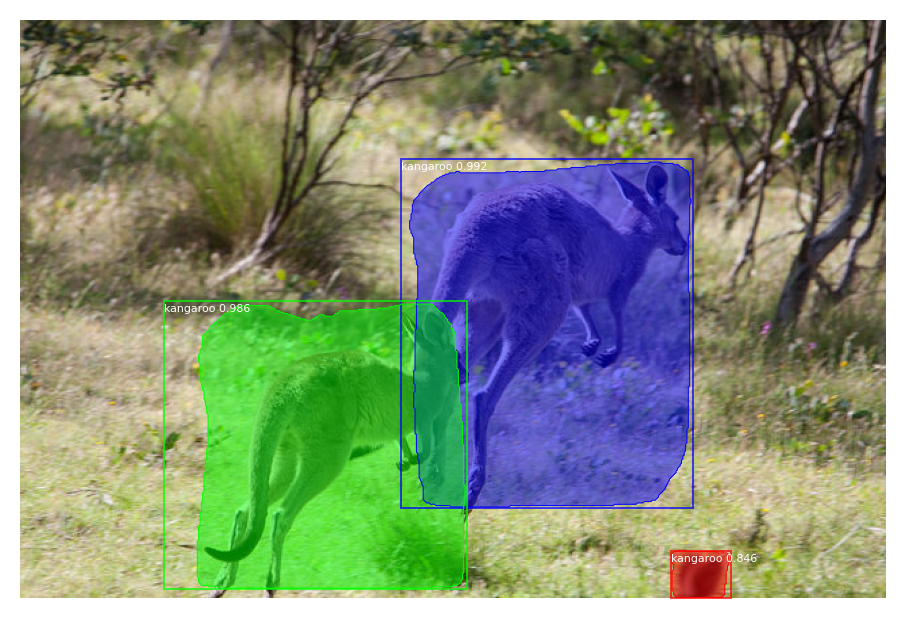

In [24]:
import cv2

CLASS_NAMES = ['BG', 'kangaroo']

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "coco_inference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath="Kangaro_mask_rcnn_trained.h5", 
                   by_name=True)

# load the input image, convert it from BGR to RGB channel
image = cv2.imread("./kangaroo-transfer-learning/kangaroo/images/00060.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
from mrcnn import visualize
visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])
